In [764]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [765]:
from google.colab import drive, files
drive.mount('/content/drive')
rootpath = '/content/drive/Shareddrives/KW phase1 repo'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [766]:
import sys
sys.path.append(rootpath+'/package')
from utils.env import env
from model.qagent import QAgent
from service.measurerss import measureRSS
from model.pathlossmodel import PathLossModel, NoiseMaker

In [767]:
import csv
import pickle
import numpy as np
from scipy.special import comb, perm
from itertools import combinations
from service.combinationset import combinationSet
from model.uav import UAV
import keras

In [768]:
div = 100
pick = 3
threshold = 0.065+0.025
fileFolder = "/0808_3_v2"

In [769]:
# load vae model
from keras import backend as K
modelPath = rootpath+"/datas/trainingModel/V2_VAENoanchorModel_300sample_8UAV_8uUAV_div"+str(div)
vae = keras.models.load_model(modelPath, custom_objects={'latent_dim': env.latent_dim, 'epsilon_std': env.epsilon_std})

import pickle as dill
_UAVsSamples = {}
iSample = 0
with open(rootpath+"/datas/anomalySDPResult"+fileFolder+"/UAVsSamples_pick{}div{}_300.npy".format(pick,div), 'rb') as f:
  while True:
    if iSample >= env.LOAD_SAMPLES_FOR_AE:
       break
    try:
      _UAVsSamples[iSample] = dill.load(f)
      iSample += 1
    except EOFError:
      break
UAVsSamples = _UAVsSamples
print(UAVsSamples)


{0: {0: <model.uav.UAV object at 0x7f9599891750>, 1: <model.uav.UAV object at 0x7f95a9130d50>, 2: <model.uav.UAV object at 0x7f95b8363190>, 3: <model.uav.UAV object at 0x7f95a5c26950>, 4: <model.uav.UAV object at 0x7f959dfced10>, 5: <model.uav.UAV object at 0x7f95a14c8090>, 6: <model.uav.UAV object at 0x7f959c95c850>, 7: <model.uav.UAV object at 0x7f959c95c290>, 8: <model.uav.UAV object at 0x7f959c95ce10>, 9: <model.uav.UAV object at 0x7f959c98ac50>, 10: <model.uav.UAV object at 0x7f959c98a610>, 11: <model.uav.UAV object at 0x7f959f0d5cd0>, 12: <model.uav.UAV object at 0x7f959c961f90>, 13: <model.uav.UAV object at 0x7f959c961a10>, 14: <model.uav.UAV object at 0x7f959c9613d0>, 15: <model.uav.UAV object at 0x7f959c96acd0>}, 1: {0: <model.uav.UAV object at 0x7f95a1c70cd0>, 1: <model.uav.UAV object at 0x7f95adbe7c50>, 2: <model.uav.UAV object at 0x7f95adbe7710>, 3: <model.uav.UAV object at 0x7f959c976fd0>, 4: <model.uav.UAV object at 0x7f959c976a50>, 5: <model.uav.UAV object at 0x7f95ba80d

In [770]:
# 將93種分組方式建表，查詢方式為那些組沒有哪些人。
# output: 所有可能的組合；input: 要被剔除的人。

In [771]:
pathLossModel = PathLossModel()
pathLossModel.noiseMaker = NoiseMaker(mean = env.noiseMean, deviation = env.noiseDeviation)

In [772]:
groupListSamples = combinationSet(UAVsSamples)
SizeOfGroupsCombination = 0
for INumberOfCombination, GroupsOfConbination  in groupListSamples[0].items():
  for IConbination in GroupsOfConbination:
    SizeOfGroupsCombination+=1

In [773]:
_sdpResultsDatas = []
for j in range(env.N_ngps):
  with open(rootpath+"/datas/anomalySDPResult"+fileFolder+"/test_position{}_pickerror{}_deviation{}_300.csv".format(j,pick,div), "r") as _csv:
    csvReader = list (csv.reader(_csv, delimiter=',', quoting=csv.QUOTE_NONNUMERIC))
    _sdpResultsDatas.append(csvReader)
ShapeOfSDPResultsData = np.array(_sdpResultsDatas).shape
sdpResultsDatas = np.array(_sdpResultsDatas).reshape(env.N_ngps,ShapeOfSDPResultsData[1]//SizeOfGroupsCombination,SizeOfGroupsCombination,env.DIMENSION)
PositionOfTargetsUAVOfGroupOfSample = sdpResultsDatas.transpose((1,2,0,3))
np.array(PositionOfTargetsUAVOfGroupOfSample).shape
PositionOfTargetsUAVOfGroupOfSample = PositionOfTargetsUAVOfGroupOfSample

In [774]:
PositionOfTargetsUAVOfGroupOfSample.shape

(79, 93, 8, 3)

In [775]:
from service.combinationset import groupingFromSet
from model.sdp import calculateSDP
states = {}
currentSdpResultsDatas = {}
groupLists = combinationSet(UAVsSamples)
for iSample in UAVsSamples:
  currentSdpResultsDatas[iSample]= {}
  states[iSample] = []
  for s, groupList in groupLists[iSample].items():
    for group in groupList:
      states[iSample].append(group)
  for iState, state in enumerate(states[iSample]):
    groupOfState = groupingFromSet(state)  
    currentSdpResultsDatas[iSample][iState] = []  
    for iNumberOfGroup in groupOfState:
      if len(groupOfState[iNumberOfGroup]) > 0:
        for group in groupOfState[iNumberOfGroup]:
          if group in states[iSample]:
            indexOfGroup = states[iSample].index(group)
            currentSdpResultsDatas[iSample][iState].append(PositionOfTargetsUAVOfGroupOfSample[iSample][indexOfGroup])

In [776]:
from itertools import combinations
allEstimateGroups = {}
states = {}
for iSample in UAVsSamples:
  allEstimateGroups[iSample] = {}
  UAVsSample = UAVsSamples[iSample]
  groupListSample = combinationSet({0:UAVsSample})[0]

  states[iSample] = []
  for s, groupList in groupListSample.items():
    for group in groupList:
      states[iSample].append(group)

  for iState, state in enumerate(states[iSample]):
    # print(len(state),len(state)-(env.DIMENSION+1))
    for kickNumber in range(len(state)-(env.DIMENSION+1)):
      for ikick in range(kickNumber+1):
        estimateGroups = list(combinations(state,len(state)-ikick))
        allEstimateGroups[iSample][iState] = estimateGroups

In [777]:
MSE = lambda x,y: np.mean(np.square(np.array(x)-np.array(y)), axis=1)

In [778]:
sdpOfSubGroupOfState= {} # state > index in estimateGroup > sdp
for iSample in UAVsSamples:
  sdpOfSubGroupOfState[iSample]= {}
  pathLossModel = PathLossModel()
  for iEstimateGroups in allEstimateGroups[iSample]:
    sdpOfSubGroup = {}
    sdpResultsDatas = None
    rawDatas = []
    ReadSampleSize = 1
    estimateGroups = list(map(list, allEstimateGroups[iSample][iEstimateGroups]))
    groupSize = np.array(estimateGroups).shape[0]
    for iEstimateGroup, estimateGroup in enumerate(estimateGroups):
      stateIndex = states[iSample].index(estimateGroup)
      sdpOfSubGroup[iEstimateGroup] = currentSdpResultsDatas[iSample][stateIndex]
    sdpOfSubGroupOfState[iSample][iEstimateGroups] = sdpOfSubGroup

In [779]:
vaeOutputs = {}
normalizeVAETestingDatas = {}
for iSample in UAVsSamples:
  print("iSample",iSample)
  vaeOutputs[iSample] = []
  normalizeVAETestingDatas[iSample] = []
  for iState in allEstimateGroups[iSample]:
    estimateGroups = []    
    for iEstimateGroup, estimateGroup in enumerate(allEstimateGroups[iSample][iState]):
      estimateGroups.append(estimateGroup)
    dualGroupingTestingData = []
    for groupOfI in estimateGroups:
      for groupOfJ in estimateGroups:
        indexOfSubGroupInStateOfI = allEstimateGroups[iSample][iState].index(groupOfI)
        indexOfSubGroupInStateOfJ = allEstimateGroups[iSample][iState].index(groupOfJ)
        firstTrainingPickGroupData = np.array(sdpOfSubGroupOfState[iSample][iState][indexOfSubGroupInStateOfI]).copy().tolist()
        secondTrainingPickGroupData = np.array(sdpOfSubGroupOfState[iSample][iState][indexOfSubGroupInStateOfJ]).copy().tolist()
        # list (map(lambda i: firstTrainingPickGroupData.append(np.array(anchors[iSample][i].observedPosition).reshape(1,3)), range(env.N_gps)))
        # list (map(lambda i: secondTrainingPickGroupData.append(np.array(anchors[iSample][i].observedPosition).reshape(1,3)), range(env.N_gps)))
        dualGroupingTestingData.append([firstTrainingPickGroupData, secondTrainingPickGroupData])
    dualGroupingTestingData = np.array(dualGroupingTestingData).astype('float32')  
    VAETestingData = dualGroupingTestingData.reshape(len(dualGroupingTestingData), np.prod(dualGroupingTestingData.shape[1:]))
    # VAETestingData = dualGroupingTestingData.reshape((dualGroupingTestingData.shape[0],
    #       dualGroupingTestingData.shape[3],
    #       dualGroupingTestingData.shape[1],
    #       dualGroupingTestingData.shape[4],
    #       dualGroupingTestingData.shape[2]))   
    data_min = 0
    data_max = max(max(env.X_RANGE,env.Y_RANGE),env.Z_RANGE)
    normalizeVAETestingData = (VAETestingData-data_min)/(data_max - data_min)
    normalizeVAETestingData = normalizeVAETestingData.astype('float32')
    # print(np.array(normalizeVAETestingData).shape)
    vaeOutput = vae.predict(normalizeVAETestingData, batch_size = 2048*4)
    vaeOutputs[iSample].append(vaeOutput)
    normalizeVAETestingDatas[iSample].append(normalizeVAETestingData)



iSample 0
iSample 1
iSample 2
iSample 3
iSample 4
iSample 5
iSample 6
iSample 7
iSample 8
iSample 9
iSample 10
iSample 11
iSample 12
iSample 13
iSample 14
iSample 15
iSample 16
iSample 17
iSample 18
iSample 19
iSample 20
iSample 21
iSample 22
iSample 23
iSample 24
iSample 25
iSample 26
iSample 27
iSample 28
iSample 29
iSample 30
iSample 31
iSample 32
iSample 33
iSample 34
iSample 35
iSample 36
iSample 37
iSample 38
iSample 39
iSample 40
iSample 41
iSample 42
iSample 43
iSample 44
iSample 45
iSample 46
iSample 47
iSample 48
iSample 49
iSample 50
iSample 51
iSample 52
iSample 53
iSample 54
iSample 55
iSample 56
iSample 57
iSample 58
iSample 59
iSample 60
iSample 61
iSample 62
iSample 63
iSample 64
iSample 65
iSample 66
iSample 67
iSample 68
iSample 69
iSample 70
iSample 71
iSample 72
iSample 73
iSample 74
iSample 75
iSample 76
iSample 77
iSample 78


In [780]:
f = open(rootpath+"/datas/anomalySDPResult"+fileFolder+"/VAE_vaeOutputs_pick{}_div{}.pkl".format(pick,div), "wb")
pickle.dump(vaeOutputs, f)
f.close()

f = open(rootpath+"/datas/anomalySDPResult"+fileFolder+"/VAE_normalizeVAETestingDatas_pick{}_div{}.pkl".format(pick,div), "wb")
pickle.dump(normalizeVAETestingDatas, f)
f.close()

In [781]:
f = open(rootpath+"/datas/anomalySDPResult"+fileFolder+"/VAE_vaeOutputs_pick{}_div{}.pkl".format(pick,div), "rb")
vaeOutputs = pickle.load(f)
f.close()
f = open(rootpath+"/datas/anomalySDPResult"+fileFolder+"/VAE_normalizeVAETestingDatas_pick{}_div{}.pkl".format(pick,div), "rb")
normalizeVAETestingDatas = pickle.load(f)
f.close()

In [782]:
optimalMSE = {}
optimalMSEGroup = {}
def runVAEOutput(iSample):
  print("iSample",iSample)
  _optimalMSE = []
  _optimalMSEGroup = []
  UAVsSample = UAVsSamples[iSample]
  
  for iState in allEstimateGroups[iSample]:
    try:
      mse = MSE(vaeOutputs[iSample][iState], normalizeVAETestingDatas[iSample][iState])
      # if iState %10 == 0:
        # print("iState:",iSample,iState)
      _optimalMSE.append(mse)
      _optimalMSEGroup.append(states[iSample][iState])
    except:
      continue    
  optimalMSE[iSample] = _optimalMSE
  optimalMSEGroup[iSample] = _optimalMSEGroup
  print("finish")
for iSample in UAVsSamples:
  runVAEOutput(iSample)

iSample 0
finish
iSample 1
finish
iSample 2
finish
iSample 3
finish
iSample 4
finish
iSample 5
finish
iSample 6
finish
iSample 7
finish
iSample 8
finish
iSample 9
finish
iSample 10
finish
iSample 11
finish
iSample 12
finish
iSample 13
finish
iSample 14
finish
iSample 15
finish
iSample 16
finish
iSample 17
finish
iSample 18
finish
iSample 19
finish
iSample 20
finish
iSample 21
finish
iSample 22
finish
iSample 23
finish
iSample 24
finish
iSample 25
finish
iSample 26
finish
iSample 27
finish
iSample 28
finish
iSample 29
finish
iSample 30
finish
iSample 31
finish
iSample 32
finish
iSample 33
finish
iSample 34
finish
iSample 35
finish
iSample 36
finish
iSample 37
finish
iSample 38
finish
iSample 39
finish
iSample 40
finish
iSample 41
finish
iSample 42
finish
iSample 43
finish
iSample 44
finish
iSample 45
finish
iSample 46
finish
iSample 47
finish
iSample 48
finish
iSample 49
finish
iSample 50
finish
iSample 51
finish
iSample 52
finish
iSample 53
finish
iSample 54
finish
iSample 55
finish
iS

In [783]:
# loadanomaly = np.load(rootpath+"/datas/anomalySDPResult"+"/0706/anomalyUAVs_pick1div{}_300.npy".format(40),allow_pickle=True)
import pickle as dill
anomalyUAVs = []
with open(rootpath+"/datas/anomalySDPResult"+fileFolder+"/anomalyUAVs_pick{}div{}_300.npy".format(pick,div), 'rb') as f:
  while True:
    try:
      anomalyUAVs.append(dill.load(f))
    except EOFError:
      break
print(anomalyUAVs)

[[1, 2, 12], [8, 13, 15], [3, 6, 15], [1, 2, 9], [0, 10, 11], [8, 14, 15], [4, 12, 15], [4, 7, 12], [5, 10, 15], [2, 12, 15], [3, 10, 13], [0, 7, 13], [3, 4, 6], [2, 10, 11], [8, 9, 13], [10, 13, 14], [9, 10, 15], [1, 5, 11], [0, 6, 8], [4, 6, 14], [0, 3, 13], [3, 4, 14], [10, 12, 13], [4, 9, 10], [3, 4, 14], [0, 4, 11], [1, 7, 9], [2, 9, 14], [2, 3, 11], [3, 8, 14], [2, 7, 11], [1, 9, 14], [3, 5, 6], [5, 9, 10], [4, 12, 14], [2, 3, 6], [2, 10, 15], [5, 7, 10], [6, 10, 15], [0, 2, 5], [0, 3, 4], [2, 10, 13], [4, 10, 14], [1, 4, 15], [2, 4, 11], [0, 6, 14], [3, 12, 14], [7, 10, 15], [3, 9, 12], [5, 9, 15], [6, 11, 14], [11, 12, 14], [4, 13, 15], [3, 8, 11], [7, 11, 13], [6, 14, 15], [9, 10, 13], [0, 11, 13], [0, 1, 10], [4, 5, 7], [0, 7, 11], [1, 5, 15], [0, 10, 14], [4, 5, 15], [0, 2, 4], [5, 7, 9], [2, 3, 6], [3, 12, 15], [0, 5, 14], [0, 5, 14], [5, 6, 12], [1, 7, 10], [0, 7, 10], [5, 6, 8], [2, 3, 10], [2, 6, 10], [0, 4, 13], [0, 1, 2], [5, 6, 7]]


In [784]:
# import pickle as dill
# _anomalyUAVsSamples = {}
# # anomalyUAVs = []
# iSample = 0
# with open(rootpath+"/datas/anomalySDPResult"+fileFolder+"/UAVsSamples_pick{}div{}_300.npy".format(pick,div), 'rb') as f:
#   while True:
#     if iSample >= env.LOAD_SAMPLES_FOR_AE:
#        break
#     try:
#       _anomalyUAVsSamples[iSample] = dill.load(f)
#       iSample += 1
#     except EOFError:
#       break
# anomalyUAVsSamples = _anomalyUAVsSamples
# print(_anomalyUAVsSamples)
# # for iSample in UAVsSample:
# #   _anomalyUAVs = []
# #   for _, uav in anomalyUAVsSamples[iSample].items():    
# #     if uav.observedPosition != uav.realPosition and uav.observedPosition != None :
# #       _anomalyUAVs.append(uav.id)
# #   anomalyUAVs.append(_anomalyUAVs)
# # print(anomalyUAVs)

In [785]:
# anomalyUAVsSample = {}
# for iSample in UAVsSamples:
#   anomalyUAV = []
#   for IDOfUAV in UAVsSamples[iSample]:
#     uav = UAVsSamples[iSample][IDOfUAV]
#     if not uav.observedPosition == None:
#       if not uav.observedPosition == uav.realPosition:
#         anomalyUAV.append(IDOfUAV)
#   anomalyUAVsSample[iSample] = anomalyUAV
# anomalyUAVs = anomalyUAVsSample

optimalGroup  7 : [1, 2, 4, 11, 12] 0.07924091 0.0
optimalGroup  6 : [1, 2, 4, 9, 14] 0.07487794 0.0
optimalGroup  8 : [1, 2, 4, 11, 14] 0.07430925 0.0
optimalGroup [1, 2, 4, 11, 14]
optimalGroup  35 : [4, 6, 8, 9, 11] 0.025861343 0.0
optimalGroup  10 : [3, 4, 8, 9, 11] 0.018711686 0.0
optimalGroup  0 : [3, 4, 6, 8, 9] 0.016944418 0.0
optimalGroup [3, 4, 6, 8, 9]
optimalGroup  33 : [0, 4, 7, 12, 15] 0.069969304 0.0
optimalGroup  19 : [0, 2, 7, 12, 15] 0.0628114 0.0
optimalGroup  13 : [0, 2, 4, 7, 12] 0.04578966 0.0
optimalGroup [0, 2, 4, 7, 12]
optimalGroup  42 : [2, 3, 7, 8, 13] 0.059632506 0.0
optimalGroup  51 : [3, 4, 7, 8, 13] 0.05450211 0.0
optimalGroup  46 : [2, 4, 7, 8, 13] 0.031891648 0.0
optimalGroup [2, 4, 7, 8, 13]
optimalGroup  45 : [2, 6, 9, 10, 11] 0.10824976 0.0
optimalGroup  51 : [4, 6, 9, 10, 13] 0.10315963 0.0
optimalGroup  37 : [2, 4, 6, 9, 13] 0.067301586 0.0
optimalGroup [2, 4, 6, 9, 13]
optimalGroup  13 : [0, 4, 8, 10, 14] 0.10658131 0.0
optimalGroup  20 : [0, 5, 

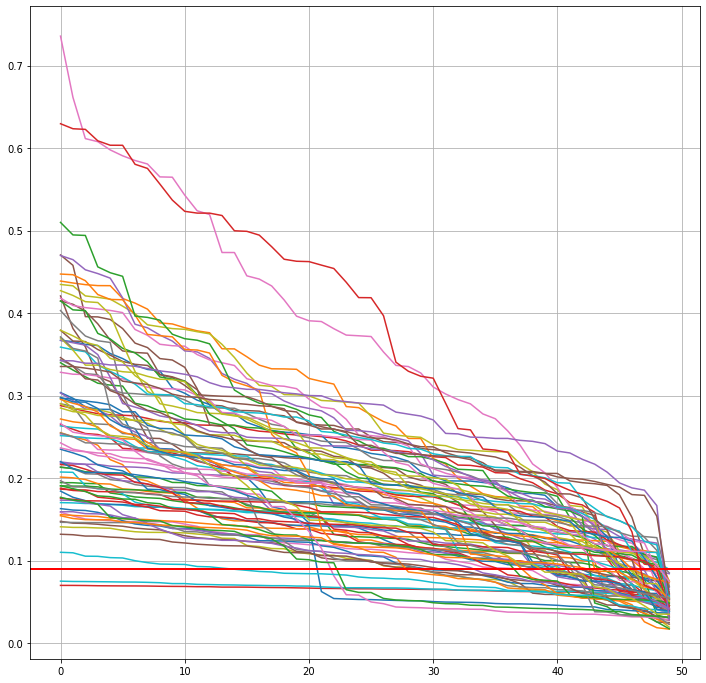

In [786]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(1,1, figsize = (12,12))
aggregateMSE = {}
# threshold = 0.065+0.025
for iSample in UAVsSamples:
  aggregateMSE[iSample] ={}  
  sortIndex = sorted(range(len(optimalMSE[iSample])), key=lambda k: np.mean(optimalMSE[iSample][k]), reverse=True)
  sortOptionalMSE = [np.mean(optimalMSE[iSample][i]) for i in sortIndex]
  for i in sortIndex[-3:]:
    print("optimalGroup ",i,":",optimalMSEGroup[iSample][i],np.mean(optimalMSE[iSample][i]),np.std(optimalMSE[iSample][i]))
  aggregateMSE[iSample] = []
  for i in range(len(optimalMSE[iSample])):
    aggregateMSE[iSample].append(np.mean(optimalMSE[iSample][i]))
  index = np.argmin(aggregateMSE[iSample])
  print("optimalGroup",optimalMSEGroup[iSample][index])
  # print("anomalyUAVs",anomalyUAVs[iSample])
  ax1.plot(sortOptionalMSE[-50:])
  ax1.axhline(y = threshold, color = 'r', linestyle = '-')
  plt.grid()


3
6.442133485324447 13.051537400751503
[ 9  6  6  5  1  2 13 11 21  1 10  7  1 10 11  4  2  1  1  9  4  1  1 90
  3 10  3  1  9 85 20  3  5  1  1 21  2 21  4  1 29 22  7 14  8  3  2 11
  5  5  4 12  1  9  4 19  5  1  1  1  2  4 13  2 16  8 28  8  4 36 10  7
 27  3  1  1  1  8 11]
79
65


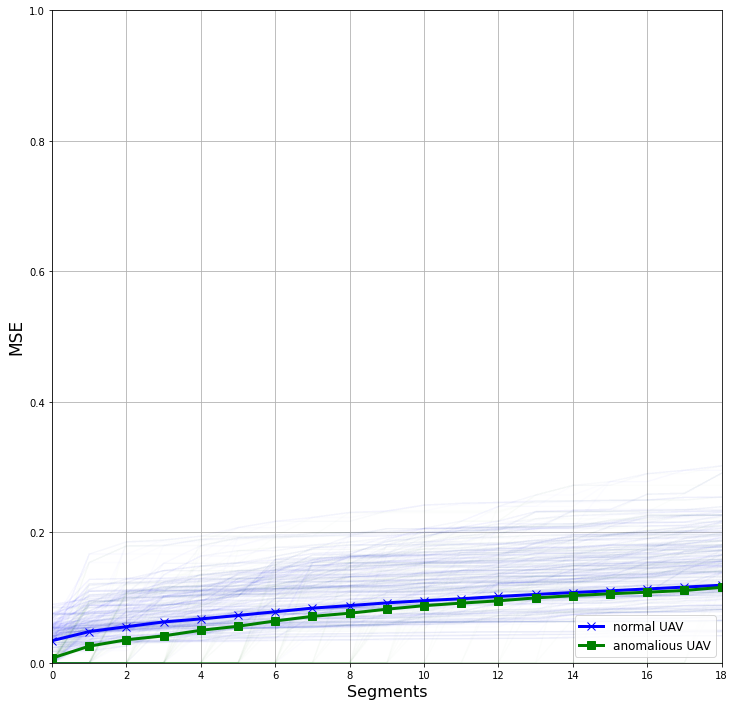

In [787]:
import matplotlib.pyplot as plt
# threshold = 0.32+0.07
print(pick)
fig, ax1 = plt.subplots(1,1, figsize = (12,12))
sumY = np.zeros(len(optimalMSE[0]))
sumAnomalyY = np.zeros(len(optimalMSE[0]))
sumthreaholdIndex = []
thresholdSampleSize = 100
for iSample in UAVsSamples:
  if not iSample < thresholdSampleSize:
    break
  sortIndex = sorted(range(len(optimalMSE[iSample])), key=lambda k: np.mean(optimalMSE[iSample][k]), reverse=False)
  sortOptionalMSE = [np.mean(optimalMSE[iSample][i]) for i in sortIndex]
  PDFWindowsMemberTable = {}
  anomalyId = []
  threaholdIndex = 0
  for iUAV,uav in UAVsSamples[iSample].items():
    if uav.observedPosition != None:
      PDFWindowsMemberTable[uav.id] = []
      if uav.observedPosition != uav.realPosition:
        anomalyId.append(uav.id)
        # print(uav.id,uav.observedPosition,uav.realPosition,np.linalg.norm(np.array(uav.observedPosition)-np.array(uav.realPosition)))
  for i in range(0,len(sortIndex)):
    if sortOptionalMSE[i] > threshold:
      threaholdIndex = i
      sumthreaholdIndex.append(i)
      break
  # print(WindowsMemberTable)
  for iWindows in range(0,len(sortIndex)):
    memberTable = {}
    for groupMember in optimalMSEGroup[iSample][sortIndex[iWindows]]:
      try:
        memberTable[groupMember] += sortOptionalMSE[iWindows]
      except:
        memberTable[groupMember] = sortOptionalMSE[iWindows]
    for UAVId in PDFWindowsMemberTable:
      isHaveValue = False
      for member, value in memberTable.items():
        if member == UAVId:
          PDFWindowsMemberTable[UAVId].append(value)
          isHaveValue = True
      if not isHaveValue:
        if len(PDFWindowsMemberTable[UAVId]) > 0:
          PDFWindowsMemberTable[UAVId].append(PDFWindowsMemberTable[UAVId][-1])
        else:
          PDFWindowsMemberTable[UAVId].append(0)
  _sumY = np.zeros(len(optimalMSE[iSample]))
  _sumAnomalyY = np.zeros(len(optimalMSE[iSample]))
  for UAVId in PDFWindowsMemberTable:
    # print(UAVId, PDFWindowsMemberTable[UAVId])
    from scipy.interpolate import make_interp_spline
    x = np.arange(0,len(PDFWindowsMemberTable[UAVId]))
    y = PDFWindowsMemberTable[UAVId]
    # model=make_interp_spline(x,y)
    # xs=np.linspace(1,15,5000)
    # ys=model(xs)
    lineColor = 'b'
    if UAVId in anomalyId:
      lineColor = 'g'
    ax1.plot(x,y,linestyle='-', c=lineColor, alpha=1/(1*thresholdSampleSize))
    if UAVId in anomalyId:
      for iyv, _xv in enumerate(y):
        _sumAnomalyY[iyv] += _xv
    else:
      for iyv, _yv in enumerate(y):
        _sumY[iyv] += _yv
  # print(_sumY)
  sumY += _sumY/(env.N_gps - len(anomalyId))
  sumAnomalyY += _sumAnomalyY/(len(anomalyId))
    # ax1.legend()
  # ax1.plot( np.arange(0,len(sortOptionalMSE)),sortOptionalMSE[::-1])
  # ax1.axvline(x=threaholdIndex,linestyle='-', c='r', alpha=1/(2*thresholdSampleSize))
  # ax1.legend()
meanY = sumY/(thresholdSampleSize)
meanAnomalyY = sumAnomalyY/(thresholdSampleSize)
import numpy as np, scipy.stats as st
lower,upper = st.t.interval(0.95, len(sumthreaholdIndex)-1, loc=np.mean(sumthreaholdIndex), scale=st.sem(sumthreaholdIndex))
print(lower,upper)
ax1.plot(x,meanY, label= "normal UAV",linestyle='-', c='b', linewidth=3, marker = 'x', markersize=8)
ax1.plot(x,meanAnomalyY, label= "anomalious UAV",linestyle='-', c='g', linewidth=3, marker = 's', markersize=8)
sumthreaholdIndex = np.array(sumthreaholdIndex)
print(sumthreaholdIndex)
# sumthreaholdIndex = np.array(sumthreaholdIndex)[sumthreaholdIndex >lower]
print(len(sumthreaholdIndex))
sumthreaholdIndex = sumthreaholdIndex[sumthreaholdIndex < upper]
print(len(sumthreaholdIndex))
# ax1.axvline(x=np.mean(sumthreaholdIndex), label= "cutting", c='r', linewidth=3)
ax1.legend(loc='lower right', prop={'size': 12})
ax1.set_xlabel('Segments', fontsize=16)
ax1.set_ylabel('MSE', fontsize=17)
# ax1.set_title('{} div {} pick {}'.format(dataFolder.split("_")[1], div, pick))
ax1.set_ylim([0,1])
ax1.set_xlim([0,18])
plt.grid()

# plt.savefig(rootpath+"/datas/anomalyNewSDPResult"+dataFolder+"/appearance{}_{}".format(div,pick))
# plt.savefig(rootpath+"/datas/anomalyNewSDPResult/appearanceSDSOCP{}_{}".format(div,pick))

In [788]:
# avgY = np.around(meanY, 3)
# avgAnomalyY = np.around(meanAnomalyY, 3)

avgY = list (map(lambda x: np.around(x, 3), meanY))
avgAnomalyY = list (map(lambda x: np.around(x, 3), meanAnomalyY))
print(avgY)
print(avgAnomalyY)
# print(meanY)
# print('%.3f' % meanY)


[0.034, 0.048, 0.055, 0.063, 0.067, 0.073, 0.078, 0.084, 0.088, 0.092, 0.095, 0.098, 0.102, 0.105, 0.108, 0.11, 0.113, 0.116, 0.119, 0.122, 0.124, 0.127, 0.129, 0.132, 0.135, 0.137, 0.14, 0.143, 0.146, 0.15, 0.153, 0.156, 0.159, 0.161, 0.164, 0.168, 0.17, 0.174, 0.177, 0.18, 0.184, 0.187, 0.19, 0.194, 0.199, 0.204, 0.208, 0.213, 0.217, 0.222, 0.226, 0.232, 0.237, 0.244, 0.249, 0.256, 0.262, 0.267, 0.275, 0.282, 0.291, 0.299, 0.307, 0.317, 0.329, 0.339, 0.356, 0.368, 0.381, 0.399, 0.429, 0.451, 0.471, 0.499, 0.529, 0.558, 0.608, 0.677, 0.729, 0.779, 0.828, 0.882, 0.936, 1.03, 1.113, 1.229, 1.32, 1.641, 2.142, 2.524, 2.87, 3.669, 6.959]
[0.007, 0.026, 0.035, 0.041, 0.05, 0.056, 0.064, 0.071, 0.076, 0.082, 0.088, 0.091, 0.095, 0.1, 0.103, 0.106, 0.108, 0.111, 0.116, 0.119, 0.122, 0.124, 0.128, 0.131, 0.134, 0.136, 0.139, 0.142, 0.145, 0.149, 0.152, 0.155, 0.158, 0.161, 0.164, 0.168, 0.17, 0.173, 0.176, 0.181, 0.184, 0.187, 0.19, 0.194, 0.2, 0.204, 0.209, 0.213, 0.217, 0.222, 0.226, 0.231,

In [789]:
# import matplotlib.pyplot as plt
# # threshold = 0.32+0.07
# print(pick)
# for iSample in UAVsSamples:
#   if not iSample < thresholdSampleSize:
#     break
#   sortIndex = sorted(range(len(optimalMSE[iSample])), key=lambda k: np.mean(optimalMSE[iSample][k]), reverse=False)
#   sortOptionalMSE = [np.mean(optimalMSE[iSample][i]) for i in sortIndex]
#   ListOfMSEWindowsMemberTable = {}
#   anomalyId = []
#   for iUAV,uav in UAVsSamples[iSample].items():
#     if uav.observedPosition != None:
#       ListOfMSEWindowsMemberTable[uav.id] = []
#       if uav.observedPosition != uav.realPosition:
#         anomalyId.append(uav.id)
#   print(anomalyId)
#   # print(WindowsMemberTable)
#   for iWindow in range(0,len(sortIndex)):
#     memberTable = {}
#     i = sortIndex[iWindow]
#     for groupMember in optimalMSEGroup[iSample][i]:
#       memberTable[groupMember] = np.mean(optimalMSE[iSample][i])
#     for UAVId in ListOfMSEWindowsMemberTable:
#       isHaveValue = False
#       for member, value in memberTable.items():
#         if member == UAVId:
#           ListOfMSEWindowsMemberTable[UAVId].append(value)
#           isHaveValue = True
#   print(ListOfMSEWindowsMemberTable)
#   import pandas as pd
#   import matplotlib.pyplot as plt
#   df = pd.DataFrame()
#   for uavId, MSEs in ListOfMSEWindowsMemberTable.items():
#     df[uavId] = MSEs
#   df.plot.box(title="Box Chart",showfliers=False)
#   plt.grid(linestyle="--", alpha=0.3)
#   plt.show()
#   break

In [790]:
# import matplotlib.pyplot as plt
# # threshold = 0.32+0.07
# print(pick)
# sumY = np.zeros(len(optimalMSE[0])-windowsSize)
# sumAnomalyY = np.zeros(len(optimalMSE[0])-windowsSize)
# for iSample in UAVsSamples:
#   if not iSample < thresholdSampleSize:
#     break
#   sortIndex = sorted(range(len(optimalMSE[iSample])), key=lambda k: np.mean(optimalMSE[iSample][k]), reverse=False)
#   sortOptionalMSE = [np.mean(optimalMSE[iSample][i]) for i in sortIndex]
#   ListOfMSEWindowsMemberTable = {}
#   anomalyId = []
#   for iUAV,uav in UAVsSamples[iSample].items():
#     if uav.observedPosition != None:
#       ListOfMSEWindowsMemberTable[uav.id] = []
#       if uav.observedPosition != uav.realPosition:
#         anomalyId.append(uav.id)
#   print(anomalyId)
#   # print(WindowsMemberTable)
#   for iWindow in range(0,len(sortIndex)):
#     memberTable = {}
#     i = sortIndex[iWindow]
#     for groupMember in optimalMSEGroup[iSample][i]:
#       memberTable[groupMember] = np.mean(optimalMSE[iSample][i])
#     # print(memberTable)
#     for UAVId in ListOfMSEWindowsMemberTable:
#       for member, value in memberTable.items():
#         if member == UAVId:
#           ListOfMSEWindowsMemberTable[UAVId].append(value)
#   # print(ListOfMSEWindowsMemberTable)
#   import pandas as pd
#   import matplotlib.pyplot as plt
#   anomalysMSEs = []
#   normalMSEs = []
#   for uavId, MSEs in ListOfMSEWindowsMemberTable.items():
#     if uavId in anomalyId:
#       anomalysMSEs.extend(MSEs)
#     else:
#       normalMSEs.extend(MSEs)
#   df1 = pd.DataFrame(anomalysMSEs,columns=['anomalys'])
#   df2 = pd.DataFrame(normalMSEs,columns=['normal'])
#   df = pd.concat([df1,df2], axis=1)
#   print(df)
#   df.plot.box(title="Box Chart",showfliers=False)
#   plt.grid(linestyle="--", alpha=0.3)
#   plt.show()
#   break

In [791]:
# threshold = 0.065+0.025
memberTableSample = {}
for iSample in UAVsSamples:
  sortIndex = sorted(range(len(optimalMSE[iSample])), key=lambda k: np.mean(optimalMSE[iSample][k]), reverse=True)
  sortOptionalMSE = [np.mean(optimalMSE[iSample][i]) for i in sortIndex]

  memberTable = {}
  for i in sortIndex:
    if np.mean(optimalMSE[iSample][i]) < threshold:
      print(optimalMSEGroup[iSample][i],np.mean(optimalMSE[iSample][i]),np.std(optimalMSE[iSample][i]))
      for groupMember in optimalMSEGroup[iSample][i]:
        try:
          memberTable[groupMember] += 1
        except:
          memberTable[groupMember] = 1
  memberTableSample[iSample] = memberTable
# print(memberTableSample)

memberIdSample = {}
memberAmountSample = {}
for iSample, memberTableOfSample in memberTableSample.items():
  memberId = []
  memberAmount = []
  for iMember, amount in memberTableOfSample.items():
    memberId.append(iMember)
    memberAmount.append(amount)
  memberIdSample[iSample] = memberId
  memberAmountSample[iSample] = memberAmount

[1, 2, 4, 9, 12] 0.08966246 0.0
[1, 2, 5, 9, 12] 0.08912861 0.0
[1, 4, 9, 12, 14] 0.08188901 0.0
[1, 2, 4, 5, 9] 0.08102483 0.0
[1, 4, 5, 9, 12] 0.08038663 0.0
[1, 2, 4, 9, 11] 0.07977328 0.0
[1, 2, 4, 11, 12] 0.07924091 0.0
[1, 2, 4, 9, 14] 0.07487794 0.0
[1, 2, 4, 11, 14] 0.07430925 0.0
[3, 4, 6, 9, 11] 0.0548521 0.0
[3, 4, 6, 8, 11] 0.052267715 0.0
[3, 4, 6, 8, 9, 11] 0.046517204 0.023245484
[4, 6, 8, 9, 11] 0.025861343 0.0
[3, 4, 8, 9, 11] 0.018711686 0.0
[3, 4, 6, 8, 9] 0.016944418 0.0
[0, 2, 3, 7, 12] 0.0866079 0.0
[2, 4, 6, 7, 12] 0.07865884 0.0
[0, 2, 6, 7, 12] 0.07823039 0.0
[0, 4, 7, 12, 15] 0.069969304 0.0
[0, 2, 7, 12, 15] 0.0628114 0.0
[0, 2, 4, 7, 12] 0.04578966 0.0
[2, 3, 4, 7, 8] 0.082076855 0.0
[2, 3, 4, 7, 13] 0.071837485 0.0
[2, 3, 7, 8, 13] 0.059632506 0.0
[3, 4, 7, 8, 13] 0.05450211 0.0
[2, 4, 7, 8, 13] 0.031891648 0.0
[2, 4, 6, 9, 13] 0.067301586 0.0
[0, 5, 8, 9, 10] 0.07900823 0.0
[0, 4, 5, 9, 10] 0.059639182 0.0
[1, 6, 7, 13, 15] 0.08981886 0.0
[0, 4, 7, 13, 15]

In [792]:
# goodUAVsSample = {}
# for iSample in UAVsSamples:
#   trainMean = np.mean(memberAmountSample[iSample])
#   trainStd = np.std(memberAmountSample[iSample])
#   # print(trainMean, trainStd)
#   upperBound = trainMean + trainStd*2
#   lowerBound = trainMean - trainStd*2

#   goodUAVID = []
#   for i, v in memberTableSample[iSample].items():
#     if lowerBound <= v and v <= upperBound:
#       goodUAVID.append(i)
#   # print(goodUAVID)
#   goodUAVsSample[iSample] = goodUAVID

In [793]:
goodUAVsSample = {}
for iSample in UAVsSamples:
  trainSum = np.sum(memberAmountSample[iSample])
  confidenceSum = trainSum*0.9//1
  # print(trainSum, confidenceSum,memberAmountSample)
  candidateUAV = []
  sortMap = sorted(memberTableSample[iSample].items(), key=lambda x:x[1], reverse=True)
  # print(iSample,sortMap)
  for i, v in sortMap:
    for _ in range(v):
      candidateUAV.append(i)
  # print(candidateUAV) 
  goodUAVID = []
  for i, v in enumerate(candidateUAV):
    if i <= confidenceSum:
      if v in goodUAVID:
        continue
      else:
        goodUAVID.append(v)
  # print(goodUAVID)
  goodUAVsSample[iSample] = goodUAVID
  # break

In [794]:
import pickle as dill
_anomalyUAVsSamples = {}
iSample = 0
with open(rootpath+"/datas/anomalySDPResult"+fileFolder+"/UAVsSamples_pick{}div{}_300.npy".format(pick,div), 'rb') as f:
  while True:
    if iSample >= env.LOAD_SAMPLES_FOR_AE:
       break
    try:
      _anomalyUAVsSamples[iSample] = dill.load(f)
      iSample += 1
    except EOFError:
      break
anomalyUAVsSamples = _anomalyUAVsSamples
print(_anomalyUAVsSamples)

{0: {0: <model.uav.UAV object at 0x7f95a14b5150>, 1: <model.uav.UAV object at 0x7f95a14b5910>, 2: <model.uav.UAV object at 0x7f95a14b5cd0>, 3: <model.uav.UAV object at 0x7f95a14b5b10>, 4: <model.uav.UAV object at 0x7f95ab256d10>, 5: <model.uav.UAV object at 0x7f95b8579c50>, 6: <model.uav.UAV object at 0x7f9598512ed0>, 7: <model.uav.UAV object at 0x7f9598512950>, 8: <model.uav.UAV object at 0x7f95985120d0>, 9: <model.uav.UAV object at 0x7f9598512690>, 10: <model.uav.UAV object at 0x7f9598512ad0>, 11: <model.uav.UAV object at 0x7f9598512810>, 12: <model.uav.UAV object at 0x7f9598512a50>, 13: <model.uav.UAV object at 0x7f95985125d0>, 14: <model.uav.UAV object at 0x7f9598512d50>, 15: <model.uav.UAV object at 0x7f9598512610>}, 1: {0: <model.uav.UAV object at 0x7f95a14b58d0>, 1: <model.uav.UAV object at 0x7f95985122d0>, 2: <model.uav.UAV object at 0x7f9598512390>, 3: <model.uav.UAV object at 0x7f9598512c50>, 4: <model.uav.UAV object at 0x7f9598512f90>, 5: <model.uav.UAV object at 0x7f9598512

In [795]:
TP = 0
for iSample in goodUAVsSample:
  # print(anomalyUAVs[iSample],goodUAVsSample[iSample])
  for anomlayUAV in anomalyUAVs[iSample]:
    if not anomlayUAV in goodUAVsSample[iSample] and len(goodUAVsSample[iSample]) != 0:
      TP+= 1.0

TN = 0
for iSample in goodUAVsSample:
   for _, uav in anomalyUAVsSamples[iSample].items():
      # print(iSample,uav.id,uav.observedPosition,uav.realPosition,uav.id,goodKLUAVsSample[iSample])
      if uav.id in goodUAVsSample[iSample] and uav.observedPosition == uav.realPosition and uav.observedPosition != None :
          TN += 1.0

FN = 0
for iSample in goodUAVsSample:
   for anomlayUAV in anomalyUAVs[iSample] :
      if anomlayUAV in goodUAVsSample[iSample] or len(goodUAVsSample[iSample]) == 0:
        FN += 1.0

FP = 0
for iSample in goodUAVsSample:
  #  for _, uav in UAVsSamples[iSample].items():
      # print(iSample,uav.id,goodUAVsSample[iSample],uav.observedPosition,uav.realPosition)
      # break
   for _, uav in anomalyUAVsSamples[iSample].items():
      # print(iSample,uav.id,uav.observedPosition,uav.realPosition,uav.id,goodKLUAVsSample[iSample][0])
      if uav.id not in goodUAVsSample[iSample] and uav.observedPosition == uav.realPosition and uav.observedPosition != None :
        # print("====",iSample,uav.id,goodUAVsSample[iSample],anomalyUAVs[iSample],uav.observedPosition,uav.realPosition)
        FP += 1.0
print("TP:",(TP/len(goodUAVsSample)) *100)
print("TN:",(TN/len(goodUAVsSample))*100)
print("FP:",(FP/len(goodUAVsSample)) *100)
print("FN:",(FN/len(goodUAVsSample))*100)
print("Precision:",(TP/(FP+TP))*100)
print("Recall:",(TP/(FN+TP))*100)
p = (TP/(FP+TP))*100
r = (TP/(FN+TP))*100
print("F1 score:",2*((p*r)/(p+r)))
f = open(rootpath+"/datas/datas_forAnomalyDetection/BestAnchors/0808_3_100sample_{}anomaly_{}div_SelectedAnchors_VAE_v2.pkl".format(pick,div), "wb")
pickle.dump(goodUAVsSample, f)
f.close()


TP: 177.2151898734177
TN: 493.67088607594934
FP: 6.329113924050633
FN: 122.78481012658229
Precision: 96.55172413793103
Recall: 59.07172995780591
F1 score: 73.29842931937173


In [796]:
import csv
with open(rootpath+"/datas/anomalySDPResult"+fileFolder+"/result.csv", 'a', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["{}_{}".format(div, pick), (TP/len(goodUAVsSample)) *100, (TN/len(goodUAVsSample))*100, (FP/len(goodUAVsSample)) *100, (FN/len(goodUAVsSample))*100])